# Self-Driving Car Engineer Nanodegree
 
## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images 
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector
* Normalize features and randomize a selection for training and testing
* Train a classifier Linear SVM classifier
* Implement a sliding-window technique 
* Use trained classifier to search for vehicles in images
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) 
* Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles
* Estimate a bounding box for vehicles detected


***
In this project the techniques for the vehicle detection on the road based on mono camera has been utilized. The code and some results are presented below. For more detailed description refer to the [writeup.md](https://github.com/pavlovvlad/CarND-Vehicle-Detection-Project/blob/master/writeup.md). 

## Load packages

In [8]:
# to use the numeric libraries
import numpy as np
# to use the openCV functionality
import cv2
# to load the group of images
import glob
# to read images in RGB color space
import matplotlib.image as mpimg
# to plot images
import matplotlib.pyplot as plt
# to use the HOG-functionality 
from skimage.feature import hog
# to calculate the spended time for processing 
import time
# functionality of linear SVC
from sklearn.svm import LinearSVC
# for normalization
from sklearn.preprocessing import StandardScaler
# to split the data set on test/train sub-sets 
from sklearn.model_selection import train_test_split
# to load the pickle files
import pickle
# to load files from directories
import os
# to load the SVC-classifier
import sklearn.svm as svm
# to use the grid search
from sklearn.model_selection import GridSearchCV

## Load images for training

Number of car images:  8792
Number of not car images:  8968


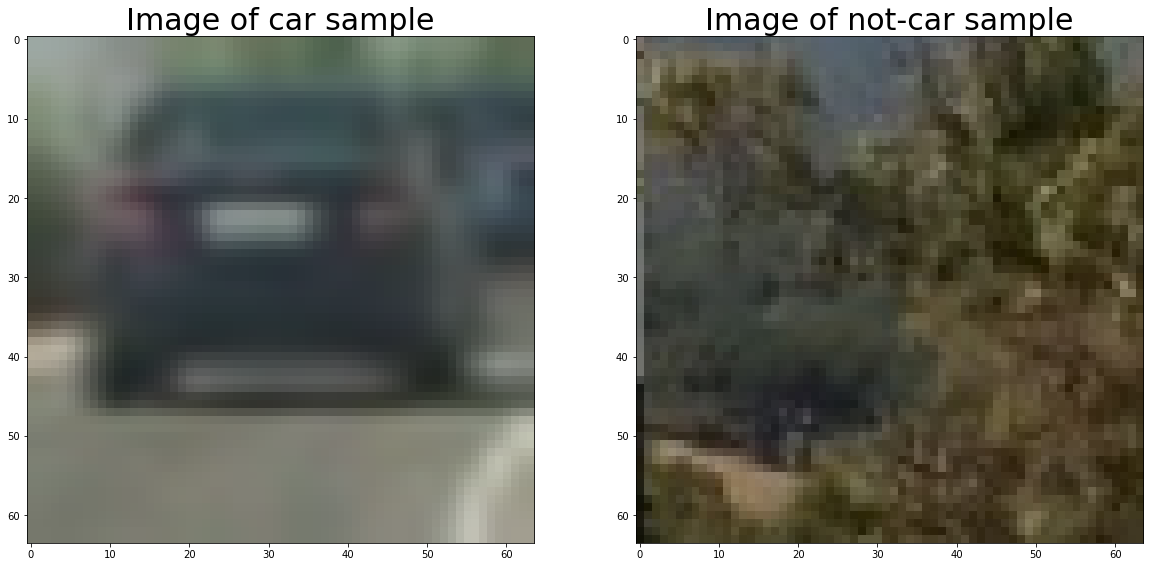

In [2]:
%matplotlib inline

# read the images with vehicles
cars = []
car_types=os.listdir("vehicles/")
for car_type in car_types:
    cars.extend(glob.glob("vehicles/"+car_type+"/*"))
print('Number of car images: ', len(cars))

# read the images with not vehicles
notcars = []
notcar_types=os.listdir("non-vehicles/")
for notcar_type in notcar_types:
    notcars.extend(glob.glob("non-vehicles/"+notcar_type+"/*"))
print('Number of not car images: ', len(notcars))

# visualize the samples
img_car = mpimg.imread(cars[1])
img_notcar = mpimg.imread(notcars[1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_car)
ax1.set_title('Image of car sample', fontsize=30)
ax2.imshow(img_notcar)
ax2.set_title('Image of not-car sample', fontsize=30)

## Functions to perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images; to applay color transform and append binned color features, as well as histograms of color, to HOG feature vector

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis :
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

## Implement a sliding-window technique

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


## Test the feature extraction

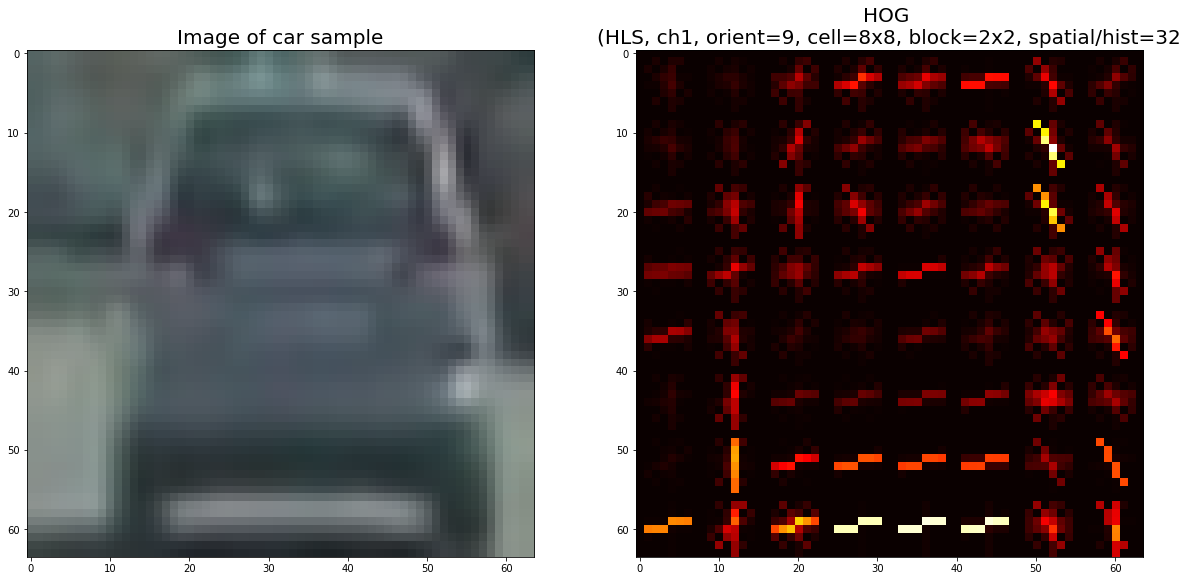

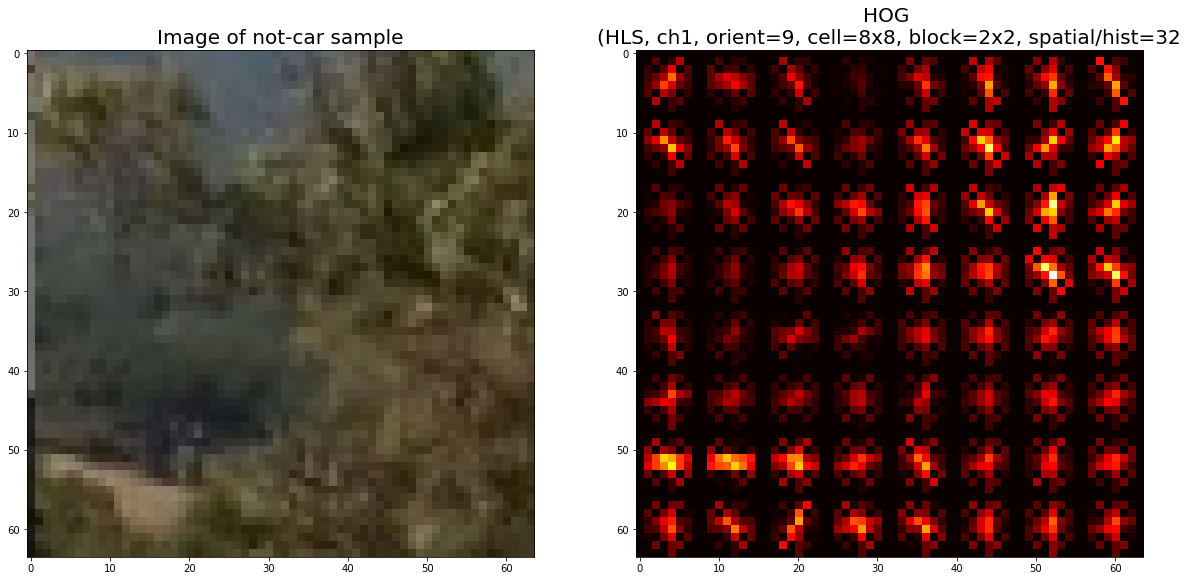

In [5]:
img_car = mpimg.imread(cars[5])

### The parameter for feature extraction
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# run the feature extraction for choosen single images
# NOTE: for hog_channel= 'ALL' the visualization is not available 
car_features, car_hog_image = single_img_features(img_car, color_space=color_space, 
                                                  spatial_size=spatial_size, hist_bins=hist_bins, 
                                                  orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_img_features(img_notcar, color_space=color_space, 
                                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                                        orient=orient, pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, 
                                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_car)
ax1.set_title('Image of car sample', fontsize=20)
ax2.imshow(car_hog_image, cmap='hot')
ax2.set_title('HOG \n(HLS, ch1, orient=9, cell=8x8, block=2x2, spatial/hist=32', fontsize=20)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_notcar)
ax1.set_title('Image of not-car sample', fontsize=20)
ax2.imshow(notcar_hog_image, cmap='hot')
ax2.set_title('HOG \n(HLS, ch1, orient=9, cell=8x8, block=2x2, spatial/hist=32', fontsize=20)


## Train a classifier Linear SVM classifier

In [6]:
# number of samples if only part of the set used for testing & optimization
sample_size = 500
# set flag to tune the hyperparameter of the classifier
flag_clf_param_tuning = False

if flag_clf_param_tuning:
    # use only part of the set for testing
    indxs = np.random.randint(0, len(cars), sample_size)
    test_cars = np.array(cars)[indxs]
    test_notcars = np.array(notcars)[indxs]
else:
    # use whole data set
    test_cars = cars
    test_notcars = notcars

### The parameter for feature extraction
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t0 = time.time()

# run the feature extraction
car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Time spent to extract the features on test set of size ", sample_size*2," : ", time.time()-t0)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', hog_channel, '-channel in ', color_space, ',', orient,'orientations, ',pix_per_cell,
    'pixels per cell,', cell_per_block, 'cells per block, spatial binning dimension of ', spatial_size, 'and',
     hist_bins, 'histogram bins by color.'  )
print('Feature vector length:', len(X_train[0]))


Time spent to extract the features on test set of size  1000  :  271.0519998073578
Using: ALL -channel in  HLS , 9 orientations,  8 pixels per cell, 2 cells per block, spatial binning dimension of  (32, 32) and 32 histogram bins by color.
Feature vector length: 8460


## Hyper-parameter tuning for classifier

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

if flag_clf_param_tuning:
    svr = svm.SVC()
    clf = GridSearchCV(svr, param_grid)
    clf.fit(X_train, y_train)
    print(clf.best_params_)

In [11]:
# Use a linear SVC 
#svc = LinearSVC()
# Use optimal classifier
svc = svm.SVC(C=1.0, kernel='rbf', gamma=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


# save the result for later use
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins

pickle.dump( dist_pickle, open( "classifier_data/svc_pickle.p", "wb" ) )

694.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9966


## Use trained classifier to search for vehicles in images

In [12]:
os.listdir("test_images/")

['.DS_Store',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

## Search for vehicles with sliding window

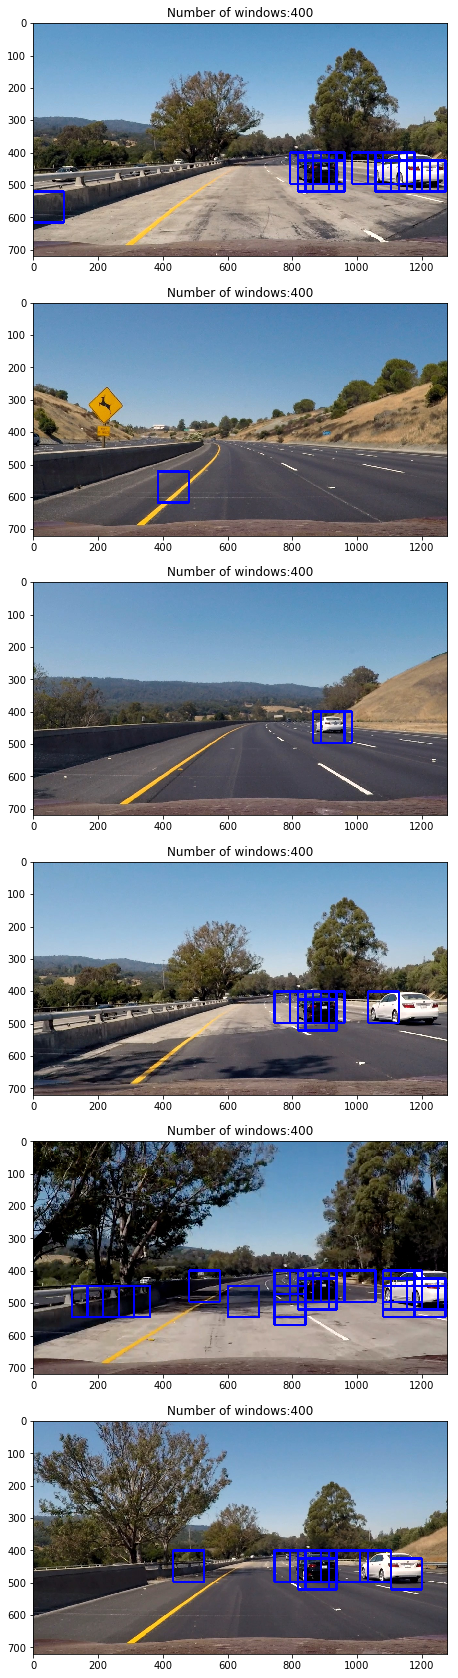

In [28]:
dist_pickle = pickle.load( open("classifier_data/svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = "ALL"

# read the test images
images = glob.glob("test_images/*.jpg")

# parameters
y_start_stop = [400, 670] # Min and max in y to search in slide_window()
overlap = 0.75
search_win = 96

# array with resulting images
window_imgs = []
plt.figure(figsize=(30, 30))

# process all given test images
for i, filename in enumerate(images):
    
    image = mpimg.imread(filename)
    draw_image = np.copy(image)

    # scale jpg-file accordingly with the png-format training data (scaled 0 to 1 by mpimg)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(search_win, search_win), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    window_imgs.append(window_img)
    plt.subplot(len(images),1,i+1)
    plt.imshow(window_img)
    plt.title('Number of windows:' + "{:.0f}".format(len(windows)))


## Search for vehicles with sliding window using sub-sampling

In [29]:
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins):
    
    box_list = []
    
    # init heatmap with zeros
    heatmap = np.zeros_like(img[:,:,0])
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # transform color map
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    return draw_img, heatmap, box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles

3 cars found
0 cars found
0 cars found
3 cars found
5 cars found
2 cars found


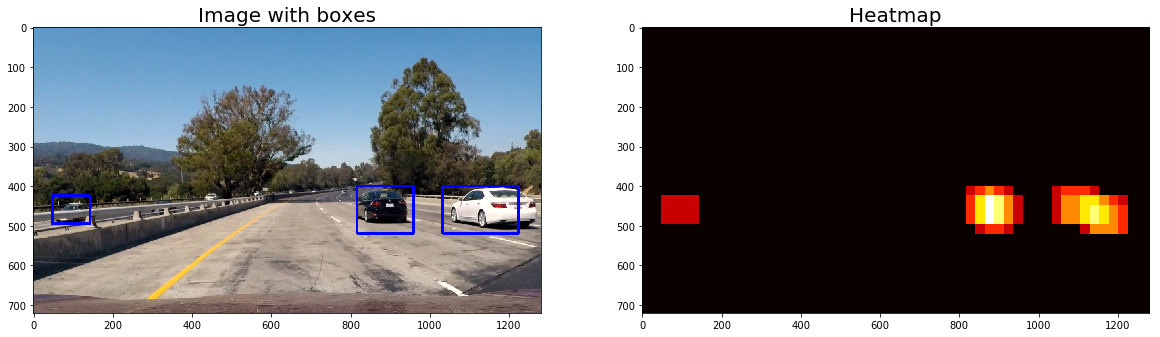

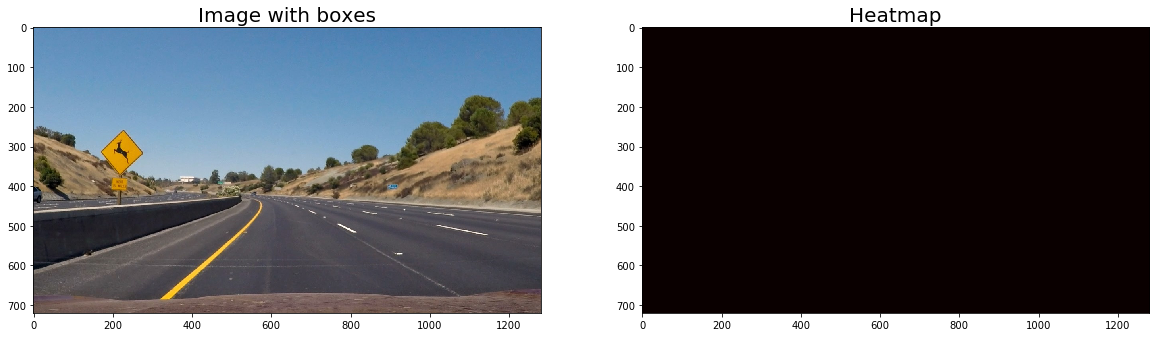

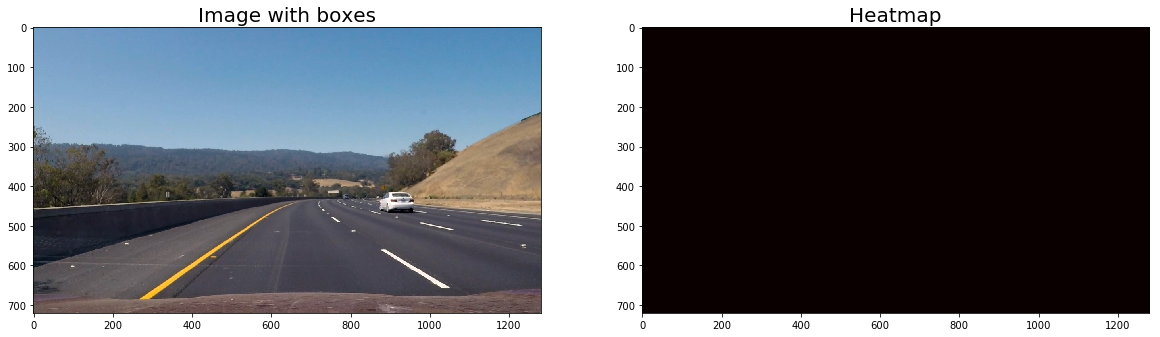

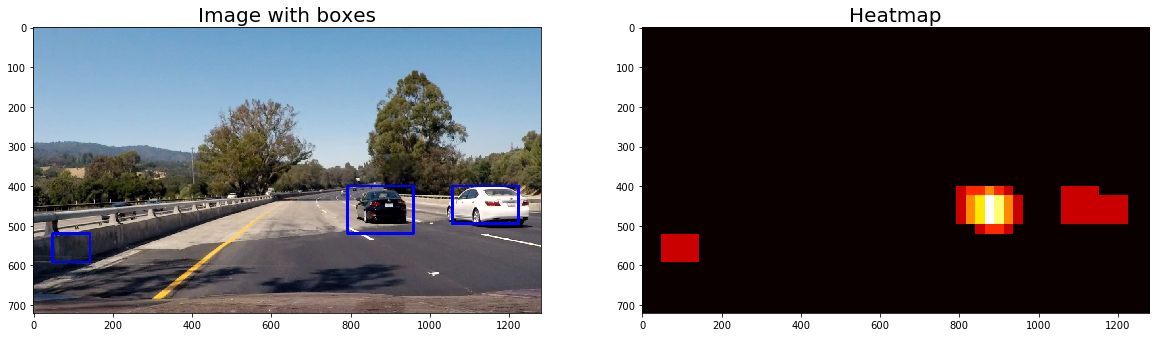

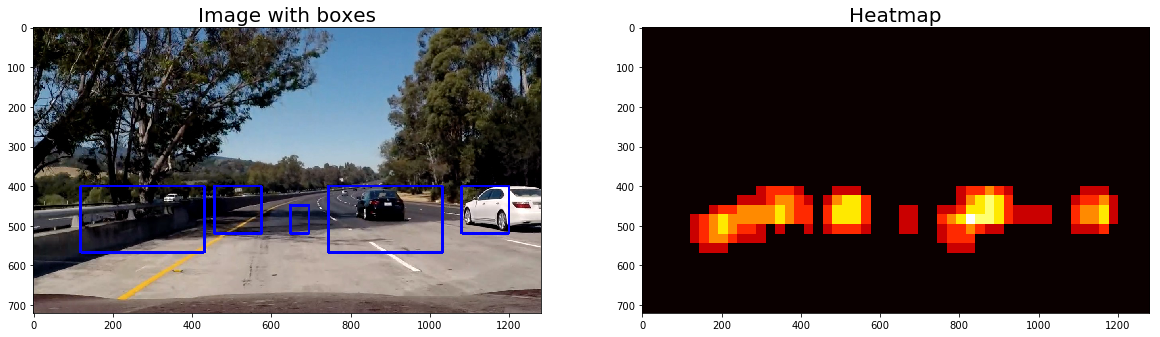

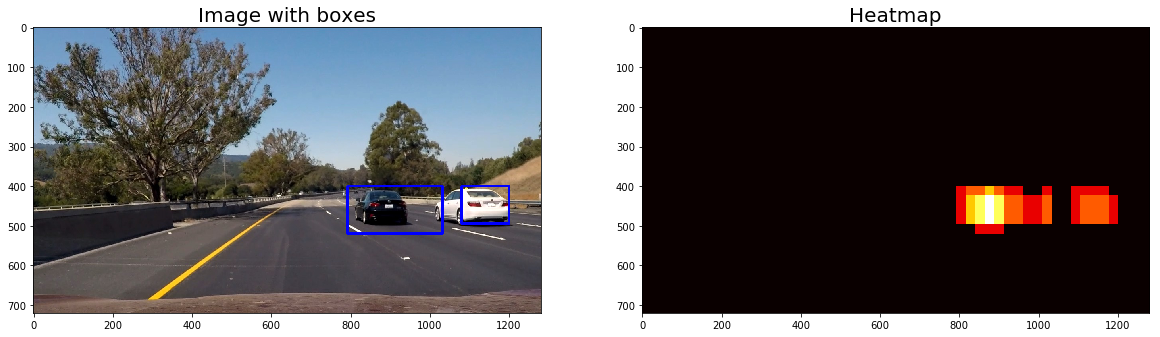

In [31]:
# set properties
ystart = y_start_stop[0]
ystop = y_start_stop[1]
scale = 1.5

# set flag in order to visualize the thresholded heatmap with labeling
flag_threshold = True

# process all given test images
for filename in images:

    image = mpimg.imread(filename)
    out_img, out_map, out_box = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, out_box)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heat = np.clip(heat, 0, 255)

    labels = label(heat)
    #labels = label(out_map)
    
    print(labels[1], 'cars found')
    
    result = draw_labeled_bboxes(np.copy(image), labels)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    if flag_threshold:
        ax1.imshow(result)
        ax1.set_title('Image with boxes', fontsize=20)
        ax2.imshow(heat, cmap='hot')
        ax2.set_title('Heatmap', fontsize=20)
    else:
        ax1.imshow(out_img)
        ax1.set_title('Image with boxes', fontsize=20)
        ax2.imshow(out_map, cmap='hot')
        ax2.set_title('Heatmap', fontsize=20)


## Estimate a bounding box for vehicles detected

In [25]:
# add class for simple tracking
class Vehicle():
    def __init__(self):
        self.detected = False
        self.recent_xfitted =[]
        self.bestx = None
        self.recent_yfitted =[]
        self.besty = None
        self.recent_wfitted =[] # width
        self.bestw = None
        self.recent_hfitted =[] # height
        self.besth = None
        
    def set_values(self, bbox, num_frames_smooth):
        self.detected = True
        self.recent_xfitted.append(bbox[0][0])
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        self.recent_yfitted.append(bbox[0][1])
        self.besty = np.mean(self.recent_yfitted, axis=0)
        self.recent_wfitted.append(np.abs(bbox[1][0] - bbox[0][0])) # width
        self.bestw = np.mean(self.recent_wfitted, axis=0)
        self.recent_hfitted.append(np.abs(bbox[1][1] - bbox[0][1])) # height
        self.besth = np.mean(self.recent_hfitted, axis=0)
        
        # remove first element if the number of frames for smoothing has been achieved
        if len(self.recent_xfitted) > num_frames_smooth:
            del self.recent_xfitted[0]
            del self.recent_yfitted[0]
            del self.recent_wfitted[0]
            del self.recent_hfitted[0]
        

## Run pipeline on a video stream (start with the test_video.mp4)

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
import collections
heatmaps = collections.deque(maxlen=10)

def process_image(image):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Search for the vehicles in image with the trained classifier
    out_img, out_map, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply 1st threshold to help remove false positives by means windows in one frame 
    heat = apply_threshold(heat, 1)
    
    # Calculate the sum in heatmap over last 10 frames
    heatmaps.append(heat)
    heatmap_sum = sum(heatmaps)
    
    # Apply 2nd threshold to remove false positive over 10 consecutive frames
    heatmap_sum = apply_threshold(heatmap_sum, 6)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap_sum, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # Create the object list
    #carslist = []
    #for car in range(labels[1]): 
    #    carslist.append(Vehicle().set_values(bbox=box_list,))
        
    # Draw the bboxes in image
    result = draw_labeled_bboxes(np.copy(image), labels)
    
    # Add some text to the frame
    cv2.putText(result,'Number of detected objects: ' + "{:.2f}".format(labels[1]), \
                (10,50), cv2.FONT_ITALIC, 1,(255,255,255), 2 ,cv2.LINE_AA)
    return result

In [ ]:
#output_video = 'result_test_video.mp4'
#clip1 = VideoFileClip('./test_video.mp4')
output_video = 'result_project_video.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4



 65%|█████████████████████████▎             | 819/1261 [37:01<09:59,  1.36s/it]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))